In [1]:
# This notebook generates a simple synthetic dataset of basal melt rates with known functions for the linear trend, seasonality/periodicity, and random variability/noise. 
# The dataset is then used to demonstrate the data preprocessing steps that follow.

In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [ ]:
# Create synthetic xarray 3 dimensional dataset of melt rate with dimensions of (x, y, time) with a linear trend and seasonal cycle and variability.
# Create this as spatially varying with a known function. Do not repeat the same series at all (x,y) locations.
np.random.seed(0)
x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)
time = pd.date_range('1992-01-01', periods=100, freq='M')
trend = np.linspace(0, 10, 100)
seasonal_cycle = np.sin(2*np.pi*np.arange(100)/12)
seasonal_variability = np.random.normal(0, 1, 100)

# Create a synthetic component of melt rate that is spatially varying with a known function that is linearly dependent on a draft variable, "draft" in the form of a function melt_rate_draft = alpha1*draft + alpha0
# This melt_rate_draft component is dependent on draft, which is a spatially varying field.

draft = np.random.normal(0, 1, (100, 100))
alpha1 = -0.1
alpha0 = 0.5
melt_rate_draft = alpha1*draft + alpha0
# melt_rate_draft = xr.DataArray(melt_rate_draft, dims=['x', 'y'], coords={'x': x, 'y': y})

melt_rate = trend + seasonal_cycle + seasonal_variability + melt_rate_draft
melt_rate = np.tile(melt_rate, (100, 100, 1))
# Add spatial variability
#for i in range(100):
#    for j in range(100):
#        melt_rate[i, j, :] += np.random.normal(0, 1, 100)
melt_rate = xr.DataArray(melt_rate, dims=['x', 'y', 'time'], coords={'x': x, 'y': y, 'time': time})


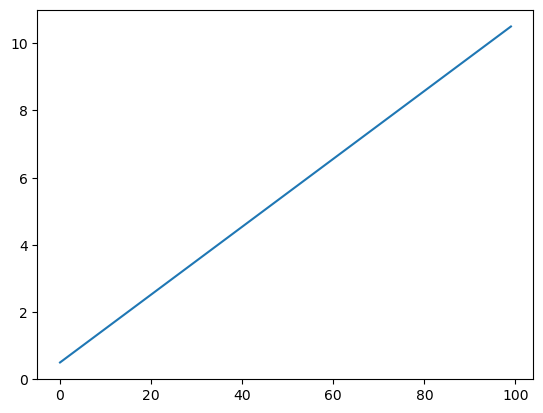

In [15]:
#plt.plot(trend)
#plt.plot(seasonal_cycle)
#plt.plot(seasonal_variability)
plt.plot(melt_rate_draft)
#melt_rate.mean(dim=['x', 'y']).plot()

In [ ]:
melt_rate_detrend = detrend_dim(melt_rate, 'time', 1).compute()